In [1]:

import pandas as pd
import numpy as np
import seaborn as sb
# import grad.py
import requests
from bs4 import BeautifulSoup
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols


data = requests.get('https://www.governing.com/gov-data/high-school-graduation-rates-by-state.html')
html = BeautifulSoup(data.content,'html.parser')

In [2]:
from scipy.stats.stats import pearsonr
import scipy as sp
from scipy.stats import norm
from scipy import stats

In [3]:
html_page = list(html.children)[3]
body = html_page.find_all('body')
tables = body[0].find_all('table')
main_table = tables[0]
main_table = list(main_table)
main_table[3].get_text().split('\n')

['',
 '',
 '\xa0United States',
 '83.2%',
 '82.3%',
 '81.4%',
 '80%',
 '79%',
 '',
 '',
 'Alabama',
 '89.3%',
 '86.3%',
 '80.0%',
 '75%',
 '72%',
 '',
 '',
 'Alaska',
 '75.6%',
 '71.1%',
 '71.8%',
 '70%',
 '68%',
 '',
 '',
 'Arizona',
 '77.4%',
 '75.7%',
 '75.1%',
 '76%',
 '78%',
 '',
 '',
 'Arkansas',
 '84.9%',
 '86.9%',
 '84.9%',
 '84%',
 '81%',
 '',
 '',
 'California',
 '82.0%',
 '81.0%',
 '80.4%',
 '79%',
 '76%',
 '',
 '',
 'Colorado',
 '77.3%',
 '77.3%',
 '76.9%',
 '75%',
 '74%',
 '',
 '',
 'Connecticut',
 '87.2%',
 '87.0%',
 '85.5%',
 '85%',
 '83%',
 '',
 '',
 'Delaware',
 '85.6%',
 '87.0%',
 '80.4%',
 '80%',
 '78%',
 '',
 '',
 'District of Columbia',
 '68.5%',
 '61.4%',
 '62.3%',
 '59%',
 '59%',
 '',
 '',
 'Florida',
 '77.9%',
 '76.1%',
 '75.6%',
 '75%',
 '71%',
 '',
 '',
 'Georgia',
 '78.8%',
 '72.5%',
 '71.7%',
 '70%',
 '67%',
 '',
 '',
 'Hawaii',
 '81.6%',
 '81.8%',
 '82.4%',
 '81%',
 '80%',
 '',
 '',
 'Idaho',
 '78.9%',
 '77.3%',
 '-',
 '-',
 '-',
 '',
 '',
 'Illinois',
 '85

In [4]:
data = []
for x in main_table[3].get_text().split('\n'):
    if x == '':
        continue
    else:
        data.append(x)

In [5]:
grad_dict = {}
i = 0
for x in range(52):
    grad_dict.update({data[i]: {2014: data[i+1].replace('%',''), 2013:data[i+2].replace('%',''),
                                2012: data[i+3].replace('%',''), 2011: data[i+4].replace('%',''),
                                2010: data[i+5].replace('%','')}})
    i+=6
    

grad_dict.pop("\xa0United States")
grad_dict = dict((k.upper().replace(' ','_'),v) for k, v in grad_dict.items())


grad_df = pd.DataFrame(grad_dict)
grad_df = grad_df.unstack().unstack()

# avoid error parsing string
# grad_df = grad_df.reset_index()
# grad_df = grad_df.rename(columns={'index':'STATE'})

grad_df = pd.melt(grad_df,var_name='YEAR',value_name='GRAD_PERCENT')

In [6]:
df = pd.read_csv('states_all.csv')
df = pd.read_csv('states_all_extended.csv')

## DATA CLENAING & SHAPING
df['LOCAL_PERCENT'] = df['LOCAL_REVENUE'] / df['TOTAL_REVENUE']
df['STATE_PERCENT'] = df['STATE_REVENUE'] / df['TOTAL_REVENUE']
df['FED_PERCENT'] = df['FEDERAL_REVENUE'] / df['TOTAL_REVENUE']

df = df[df['YEAR']<=2015]
df = df[df['YEAR']>=2010]


In [7]:
## Hypothesis: local revenue is correlated with higher test scores
## Might have to normalize test scores with revenue?

In [8]:
# df.drop('ENROLL',axis=1,inplace=True)
df.drop('PRIMARY_KEY',axis=1,inplace=True)
df = df.reset_index()
df.drop(['index'],axis=1,inplace=True)

# Merging dataframes to include graduation rate
df = pd.merge(df,grad_df,left_index=True,right_index=True)

In [9]:

df['GRAD_PERCENT'].replace(to_replace='-',value=np.NaN,inplace=True)
df['GRAD_PERCENT'] = pd.to_numeric(df['GRAD_PERCENT'])

#Cleaning and adding more columns

df.drop(['AVG_MATH_4_SCORE','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE'],axis=1,inplace=True)
df.head()

,STATE,YEAR_x,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,...,GRADES_8_TRF,GRADES_12_TRF,GRADES_1_8_TRF,GRADES_9_12_TRF,GRADES_ALL_TRF,LOCAL_PERCENT,STATE_PERCENT,FED_PERCENT,YEAR_y,GRAD_PERCENT
0,ALABAMA,2010,748889.0,7281058.0,1134111.0,3800128.0,2346819.0,7647571.0,3900492.0,2308399.0,...,37.0,17.0,779.0,114.0,935.0,0.322318,0.521920,0.155762,2010,72.0
1,ALASKA,2010,131265.0,2230338.0,366970.0,1356673.0,506695.0,2371251.0,1151630.0,856333.0,...,318.0,248.0,3038.0,1138.0,4274.0,0.227183,0.608281,0.164536,2010,68.0
2,ARIZONA,2010,963517.0,8828122.0,1579806.0,3139588.0,4108728.0,8812967.0,4223152.0,2949514.0,...,465.0,272.0,4186.0,1378.0,5603.0,0.465414,0.355635,0.178952,2010,78.0
3,ARKANSAS,2010,474897.0,5069272.0,787738.0,3677112.0,604422.0,5520387.0,2521528.0,1595730.0,...,217.0,156.0,2063.0,723.0,2863.0,0.119233,0.725373,0.155395,2010,81.0
4,CALIFORNIA,2010,6213958.0,67356719.0,9715980.0,34173911.0,23466828.0,71227111.0,34657275.0,20704755.0,...,6093.0,4872.0,55264.0,22936.0,NaN,0.348396,0.507357,0.144247,2010,76.0


In [10]:
df=df[['STATE','YEAR_x','ENROLL','GRAD_PERCENT','TOTAL_REVENUE','LOCAL_REVENUE','STATE_REVENUE','FEDERAL_REVENUE',
    'LOCAL_PERCENT','FED_PERCENT','STATE_PERCENT','TOTAL_EXPENDITURE','SUPPORT_SERVICES_EXPENDITURE','INSTRUCTION_EXPENDITURE']]

In [11]:
# New columns for money spent per student
df['total_per_student'] = df['TOTAL_REVENUE'] / df['ENROLL']
df['local_per_student'] = df['LOCAL_REVENUE'] / df['ENROLL']
df['fed_per_student'] = df['FEDERAL_REVENUE'] / df['ENROLL']
df['state_per_student'] = df['STATE_REVENUE'] / df['ENROLL']


df['GRAD_PERCENT'] = df['GRAD_PERCENT'].fillna(df['GRAD_PERCENT'].mean())
df['gov_funding'] = df['STATE_REVENUE'] + df['FEDERAL_REVENUE']
df['gov_percent'] = df['gov_funding'] / df['TOTAL_REVENUE']

In [12]:
df.head()

,STATE,YEAR_x,ENROLL,GRAD_PERCENT,TOTAL_REVENUE,LOCAL_REVENUE,STATE_REVENUE,FEDERAL_REVENUE,LOCAL_PERCENT,FED_PERCENT,STATE_PERCENT,TOTAL_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,INSTRUCTION_EXPENDITURE,total_per_student,local_per_student,fed_per_student,state_per_student,gov_funding,gov_percent
0,ALABAMA,2010,748889.0,72.0,7281058.0,2346819.0,3800128.0,1134111.0,0.322318,0.155762,0.521920,7647571.0,2308399.0,3900492.0,9.722480,3.133734,1.514391,5.074354,4934239.0,0.677682
1,ALASKA,2010,131265.0,68.0,2230338.0,506695.0,1356673.0,366970.0,0.227183,0.164536,0.608281,2371251.0,856333.0,1151630.0,16.991110,3.860092,2.795642,10.335375,1723643.0,0.772817
2,ARIZONA,2010,963517.0,78.0,8828122.0,4108728.0,3139588.0,1579806.0,0.465414,0.178952,0.355635,8812967.0,2949514.0,4223152.0,9.162394,4.264303,1.639624,3.258467,4719394.0,0.534586
3,ARKANSAS,2010,474897.0,81.0,5069272.0,604422.0,3677112.0,787738.0,0.119233,0.155395,0.725373,5520387.0,1595730.0,2521528.0,10.674466,1.272743,1.658755,7.742967,4464850.0,0.880767
4,CALIFORNIA,2010,6213958.0,76.0,67356719.0,23466828.0,34173911.0,9715980.0,0.348396,0.144247,0.507357,71227111.0,20704755.0,34657275.0,10.839584,3.776470,1.563573,5.499540,43889891.0,0.651604


In [13]:
## PLOTTING

# print
    # fig, ax = plt.subplots(figsize=(14,12))
    # sb.barplot(ax=ax,x='gov_percent',y='STATE',data=df,ci='sd')

    # fig2, ax2 = plt.subplots(figsize=(14,12))
    # sb.barplot(ax=ax2,x='LOCAL_PERCENT',y='STATE',data=df,ci='sd')

# sb.barplot(ax=ax,x='FED_PERCENT',y='STATE',data=df)

In [14]:
# ## PLOTTING
# fig, ax = plt.subplots(figsize=(14,12))
# sb.barplot(ax=ax,x='gov_percent',y='STATE',data=df,ci='sd')
# fig

# fig2, ax2 = plt.subplots(figsize=(14,12))
# sb.barplot(ax=ax2,x='LOCAL_PERCENT',y='STATE',data=df,ci='sd')
# fig2

# # fig.savefig('gov_percent.png',bbox_inches='tight')
# # fig.savefig('local_percent',bbox_inches='tight')
# sb.barplot(ax=ax,x='FED_PERCENT',y='STATE',data=df)

In [15]:
## Cost of living index per state
cost_liv_dict = { 'Hawaii': 168.6,
                'District of Columbia': 146.5,
                'New York': 135.6,
                'California': 134.3,
                'Alaska':133.5,
                'Connecticut': 131.8,
                'Massachusetts': 130.4,
                'Oregon': 129.5,
                'New Jersey': 125.6,
                'Vermont': 123.8,
                'Rhode Island': 123.3,
                'Maryland': 121.1,
                'New Hampshire': 118.2,
                'Maine': 114.7,
                'Nevada': 106.5,
                'Washington': 106.0,
                'West Virginia': 103.7,
                'Pennsylvania': 103.0,
                'Delaware': 102.8,
                'Montana': 102.7,
                'South Dakota': 102.5,
                'Colorado': 101.9,
                'Minnesota': 101.5,
                'North Dakota': 101.2,
                'Florida': 100.5,
                'Arizona': 98.8,
                'Wisconsin': 98.1,
                'South Carolina': 97.5,
                'Illinois': 96.5,
                'North Carolina': 95.8,
                'Virginia': 94.5,
                'Louisiana': 93.4,
                'Wyoming': 92.8,
                'Texas': 92.6,
                'Ohio': 92.5,
                'Utah': 92.4,
                'Nebraska': 92.3,
                'Iowa': 92.0,
                'Georgia': 91.7,
                'Missouri': 91.5,
                'Arkansas': 91.4,
                'Michigan': 91.2,
                'Kansas': 90.9,
                'Tennessee': 90.3,
                'Alabama': 90.2,
                'Kentucky': 90.0,
                'Oklahoma': 89.7,
                'Idaho': 88.2,
                'Indiana': 88.0,
                'Mississippi': 83.5,
                'New Mexico': 100.0
                }

cost_liv_dict = dict((k.upper().replace(' ','_'),v) for k, v in cost_liv_dict.items())

# Populaiton by state
state_popul = {'HAWAII': 1.43,
     'DISTRICT_OF_COLUMBIA': 0.672,
     'NEW_YORK': 19.80,
     'CALIFORNIA': 39.1,
     'ALASKA': 0.738,
     'CONNECTICUT': 3.59,
     'MASSACHUSETTS': 6.79,
     'OREGON': 4.03,
     'NEW_JERSEY': 8.96,
     'VERMONT': 0.626,
     'RHODE_ISLAND': 1.06,
     'MARYLAND': 6.01,
     'NEW_HAMPSHIRE': 1.33,
     'MAINE': 1.33,
     'NEVADA': 2.89,
     'WASHINGTON': 7.17,
     'WEST_VIRGINIA': 1.84,
     'PENNSYLVANIA': 12.8,
     'DELAWARE': 0.945,
     'MONTANA': 1.03,
     'SOUTH_DAKOTA': 0.858,
     'COLORADO': 5.46,
     'MINNESOTA': 5.49,
     'NORTH_DAKOTA': 0.756,
     'FLORIDA': 20.27,
     'ARIZONA': 6.83,
     'WISCONSIN': 5.77,
     'SOUTH_CAROLINA': 4.90,
     'ILLINOIS': 12.86,
     'NORTH_CAROLINA': 10.0,
     'VIRGINIA': 8.38,
     'LOUISIANA': 4.67,
     'WYOMING': 0.586,
     'TEXAS': 27.47,
     'OHIO': 11.6,
     'UTAH': 3.00,
     'NEBRASKA': 1.90,
     'IOWA': 3.12,
     'GEORGIA': 10.2,
     'MISSOURI': 6.08,
     'ARKANSAS': 2.98,
     'MICHIGAN': 9.92,
     'KANSAS': 2.91,
     'TENNESSEE': 6.60,
     'ALABAMA': 4.86,
     'KENTUCKY': 4.42,
     'OKLAHOMA': 3.91,
     'IDAHO': 1.65,
     'INDIANA': 6.62,
     'MISSISSIPPI': 2.99,
     'NEW_MEXICO': 2.09}

#Create cost of living index columns
df['Cost_living'] = df['STATE'].map(cost_liv_dict)
df['total_liv_index'] = df['TOTAL_REVENUE'] / df['Cost_living']
df['local_liv_index'] = df['LOCAL_REVENUE'] / df['Cost_living']
df['state_liv_index'] = df['STATE_REVENUE'] / df['Cost_living']
df['fed_liv_index'] = df['FEDERAL_REVENUE'] / df['Cost_living']

df['State_popul'] = df['STATE'].map(state_popul)


In [16]:
# df['State_popul'] >= 10

In [17]:
# df['St_popul_10plus'] = df['State_popul'] >= 10
df['St_popul_10plus'] = np.where(df['State_popul']>=10, 1, 0)
df.head()

,STATE,YEAR_x,ENROLL,GRAD_PERCENT,TOTAL_REVENUE,LOCAL_REVENUE,STATE_REVENUE,FEDERAL_REVENUE,LOCAL_PERCENT,FED_PERCENT,...,state_per_student,gov_funding,gov_percent,Cost_living,total_liv_index,local_liv_index,state_liv_index,fed_liv_index,State_popul,St_popul_10plus
0,ALABAMA,2010,748889.0,72.0,7281058.0,2346819.0,3800128.0,1134111.0,0.322318,0.155762,...,5.074354,4934239.0,0.677682,90.2,80721.263858,26017.949002,42130.022173,12573.292683,4.860,0
1,ALASKA,2010,131265.0,68.0,2230338.0,506695.0,1356673.0,366970.0,0.227183,0.164536,...,10.335375,1723643.0,0.772817,133.5,16706.651685,3795.468165,10162.344569,2748.838951,0.738,0
2,ARIZONA,2010,963517.0,78.0,8828122.0,4108728.0,3139588.0,1579806.0,0.465414,0.178952,...,3.258467,4719394.0,0.534586,98.8,89353.461538,41586.315789,31777.206478,15989.939271,6.830,0
3,ARKANSAS,2010,474897.0,81.0,5069272.0,604422.0,3677112.0,787738.0,0.119233,0.155395,...,7.742967,4464850.0,0.880767,91.4,55462.494530,6612.932166,40230.984683,8618.577681,2.980,0
4,CALIFORNIA,2010,6213958.0,76.0,67356719.0,23466828.0,34173911.0,9715980.0,0.348396,0.144247,...,5.499540,43889891.0,0.651604,134.3,501539.233060,174734.385704,254459.501117,72345.346240,39.100,1


In [18]:
## MAKING THE MODEL
lr_model = ols(formula='GRAD_PERCENT~LOCAL_PERCENT', data=df).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           GRAD_PERCENT   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.705
Date:                Sun, 08 Sep 2019   Prob (F-statistic):              0.101
Time:                        18:40:06   Log-Likelihood:                -834.55
No. Observations:                 255   AIC:                             1673.
Df Residuals:                     253   BIC:                             1680.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        82.7173      1.192     69.372      0.000      80.369      85.066
LOCAL_PERCENT    -4.4110      2.682     -1.645      0.101      -9.693       0.871
==============================================================================
Omnibus:                       32.670   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.056
Skew:                          -0.936   Prob(JB):                     1.22e-09
Kurtosis:                       3.598   Cond. No.                         7.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

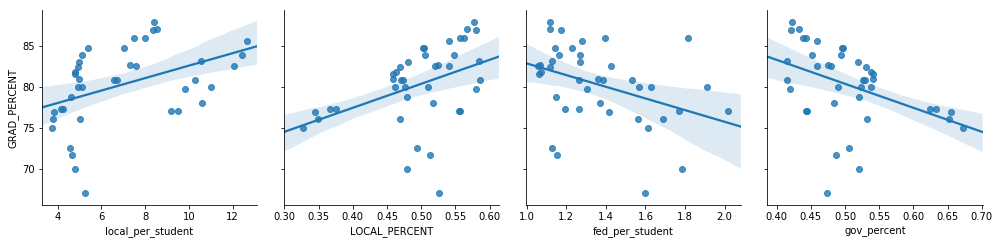

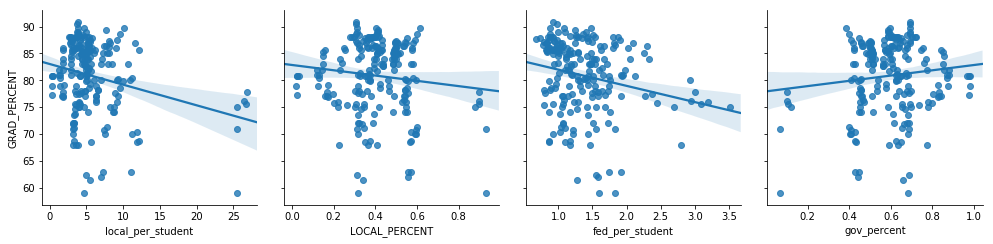

In [19]:

# Creating dataframes by state population
group1 = df[df['State_popul']>10]
group2 = df[df['State_popul']<10]

# EDA
feats = ['local_per_student', 'LOCAL_PERCENT', 'fed_per_student', 'gov_percent']
n = 4
row_groups= [feats[i:i+n] for i in range(0, len(feats), n) ]

for i in row_groups:
    group1_plt = sb.pairplot(data= group1, y_vars=['GRAD_PERCENT'],x_vars=i, kind="reg", height=3.5)
    
for i in row_groups:
    group2_plt = sb.pairplot(data= group2, y_vars=['GRAD_PERCENT'],x_vars=i, kind="reg", height=3.5)

    
# group1_.savefig('states_above_10.png',bbox_inches='tight')
# group2_.savefig('states_below_10.png',bbox_inches='tight')

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [21]:
df['LOCAL_PERCENT_scaled'] = scaler.fit_transform(df[['LOCAL_PERCENT']])
df['gov_percent_scaled'] = scaler.fit_transform(df[['gov_percent']])

In [22]:
mlr_model = ols(formula='GRAD_PERCENT~LOCAL_PERCENT_scaled+gov_percent_scaled+St_popul_10plus', data=df).fit()
mlr_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           GRAD_PERCENT   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.447
Date:                Sun, 08 Sep 2019   Prob (F-statistic):              0.237
Time:                        18:40:10   Log-Likelihood:                -834.45
No. Observations:                 255   AIC:                             1675.
Df Residuals:                     252   BIC:                             1686.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               80.7866      0.444    181.837      0.000      79.912      81.662
LOCAL_PERCENT_scaled    -0.3463      0.204     -1.695      0.091      -0.749       0.056
gov_percent_scaled       0.3463      0.204      1.695      0.091      -0.056       0.749
St_popul_10plus          0.4758      1.072      0.444      0.658      -1.635       2.587
==============================================================================
Omnibus:                       31.565   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.272
Skew:                          -0.919   Prob(JB):                     2.97e-09
Kurtosis:                       3.563   Cond. No.                     7.00e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.04e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

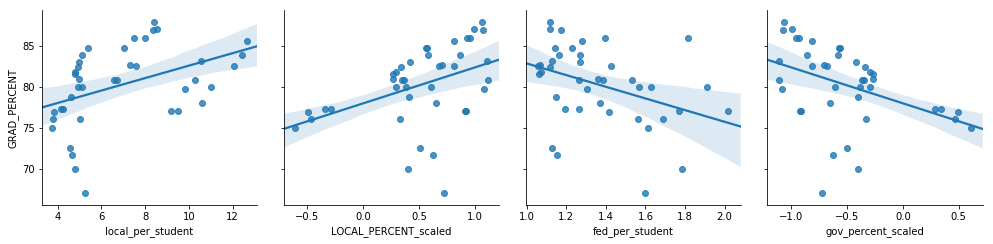

In [23]:
# EDA
group1 = df[df['State_popul']>10]

feats = ['local_per_student', 'LOCAL_PERCENT_scaled', 'fed_per_student', 'gov_percent_scaled']
n = 4
row_groups= [feats[i:i+n] for i in range(0, len(feats), n) ]

for i in row_groups:
    pp_plt = sb.pairplot(data= group1, y_vars=['GRAD_PERCENT'],x_vars=i, kind="reg", height=3.5)
    
pp_plt.savefig('states_above_10_scaled.png',bbox_inches='tight')

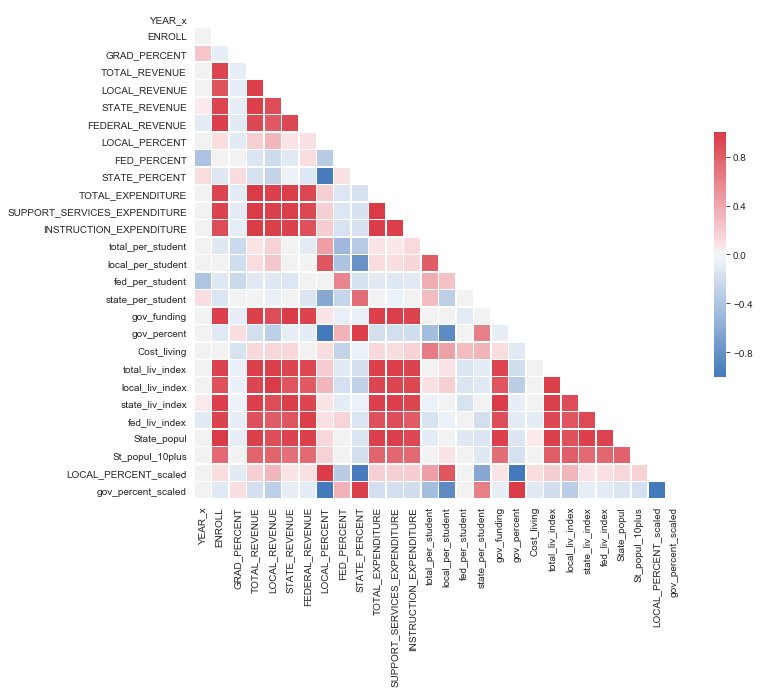

In [25]:
def CorrMtx(dfx, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    dfx = dfx.corr()

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(dfx, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sb.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sb.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sb.heatmap(dfx, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sb.heatmap(dfx, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)


CorrMtx(df, dropDuplicates = True)

In [87]:
def checkresiduals(df, target, sm_model):
    # checking for our model - Homoscedasticity,  Independence of residuals
    pred_val = sm_model.fittedvalues.copy()
    true_val = df[target].values.copy()
    residual = true_val - pred_val

    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#     fig, ax = plt.subplots(figsize=(8, 6))
    ax1.hist(residual, density=True, bins=30)
    ax2.scatter(df[target],residual)
    ax2.set_title('Residual Scatterplot')
    plt.show()
#     plt.savefig('resid.png',bbox_inches='tight')

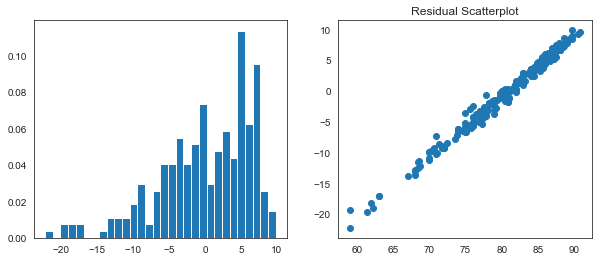

In [88]:
checkresiduals(df, 'GRAD_PERCENT', mlr_model)

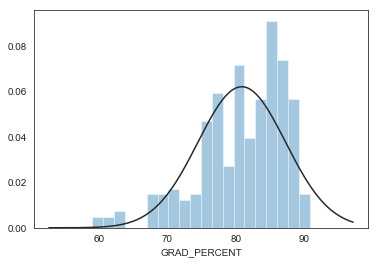

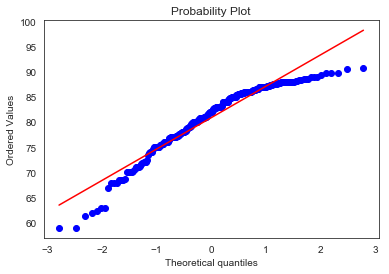

In [97]:
#histogram and normal probability plot
sb.distplot(df['GRAD_PERCENT'], fit=norm, bins=20, kde=False);
fig = plt.figure()
# fig.savefig('hist_prob.png',bbox_inches='tight')
res = stats.probplot(df['GRAD_PERCENT'], plot=plt)
# res.savefig('QQ_plot.png',bbox_inches='tight')

In [80]:
# checking for normality - QQ plot 

# fig, ax = plt.subplots(figsize=(8,6))
# sp.stats.probplot(residual, plot=ax, fit=True)